In [1]:
import ampal
import isambard
import isambard.specifications as specifications
import isambard.modelling as modelling
import isambard.optimisation as optimisation
import isambard.optimisation.evo_optimizers as ev_opts
from isambard.optimisation.evo_optimizers import Parameter
import budeff

import matplotlib.pyplot as plt
import numpy as np
import itertools
from pprint import pprint
import nglview as nv
from contextlib import redirect_stdout

%matplotlib inline

In [ ]:
def show_ball_and_stick(ampal):
    view = nv.show_text(ampal.pdb)
    view.add_ball_and_stick()
    view.remove_cartoon()
    return view

In [2]:
class APHomoTetramer(specifications.CoiledCoil):
    """Specification for creating antiparallel, homotetrameric coiled coils."""
    
    oligomeric_state = 4
    
    # The only thing that we need to define is a new `__init__` method, which defines
    # how the class is created. We get all the rest of the functionality off the
    # parent class `CoiledCoil`.
    def __init__(self, helix_length, radius, pitch, phica, zshift):
        # To kick everything off, this class runs the standard setup of the `CoiledCoil`
        # class, which gives our class all of the same attributes and methods. The
        # `super` function gives us access to the parent class. As we want to modify
        # some of the parameters before building the model, we set `auto_build` to false
        super().__init__(self.oligomeric_state, auto_build=False)
        
        # Next, we redefine the relevant default values that `CoiledCoil` has set. As
        # we have 4 helices, we have 4 values for each of these, but in this case they
        # are the same as we're making a homotetramer
        self.aas = [helix_length, helix_length, helix_length, helix_length]
        self.major_radii = [radius, radius, radius, radius]
        self.major_pitches = [pitch, pitch, pitch, pitch]
        self.z_shifts = [0, zshift, 0, zshift]
        self.phi_c_alphas = [phica, phica, phica, phica]
        
        # We need to set the orientation of the helices
        self.orientations = [1, -1, 1, -1] # antiparallel specification

        # Now we've redefined these values, we need to build the model from these
        # parameters. We can do this using the build method, which comes from
        # `CoiledCoil`
        self.build()

In [3]:
REGISTER_ADJUST = {
    'a': 0,
    'b': 102.8,
    'c': 205.6,
    'd': 308.4,
    'e': 51.4,
    'f': 154.2,
    'g': 257
}

In [4]:
sequences = ['GEIAALKQEIAALKKENAALKWEIAALKQGYY', 'GEIAALKQEIAALKKENAALKWEIAALKQGYY', 'GEIAALKQEIAALKKENAALKWEIAALKQGYY', 
             'GEIAALKQEIAALKKENAALKWEIAALKQGYY']

In [5]:
def get_bude_total_energy(ampal_object):
    return budeff.get_internal_energy(ampal_object).total_energy

In [6]:
parameters = [
    optimisation.Parameter.static('Helix Length', 32),
    optimisation.Parameter.dynamic('Radius', 6.0, 1.0),
    optimisation.Parameter.dynamic('Pitch', 200, 60),
    optimisation.Parameter.dynamic('PhiCA', REGISTER_ADJUST['f'], 27),
    optimisation.Parameter.dynamic('ZShift', 10, 10),
]

In [7]:
default_values = [x.default_value for x in parameters]
print(default_values)

[32, 6.0, 200, 154.2, 10]


### Genetic Algorithm

In [8]:
opt_ga = ev_opts.GA(APHomoTetramer, sequences, parameters, get_bude_total_energy)

In [9]:
opt_ga.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min    	max   
0  	61   	-157.656	874.977	-1853.3	1356.8
1  	61   	-913.843	571.115	-1946.57	147.139
2  	58   	-1377.56	402.162	-1990.12	-654.612
3  	84   	-1830.92	113.994	-2038.21	-1537.91
4  	52   	-1903.16	63.7023	-2043.97	-1802.75
5  	79   	-1960.97	51.859 	-2066.93	-1878.15
6  	56   	-1988.98	38.9179	-2069.64	-1918.66
7  	71   	-2016.91	33.367 	-2069.64	-1949.97
8  	70   	-2043.36	18.415 	-2070.37	-1999.99
9  	76   	-2057.71	10.1317	-2081.59	-2037.47
10 	61   	-2064   	6.23981	-2083   	-2048.79
11 	78   	-2067.05	5.67596	-2083.11	-2054.91
12 	56   	-2068.85	5.2207 	-2087.44	-2058.24
13 	71   	-2072.51	5.30238	-2087.44	-2065.98
14 	83   	-2076.82	5.3178 	-2087.44	-2069.44
15 	71   	-2081.26	3.89961	-2087.44	-2072.25
16 	78   	-2084.22	1.88729	-2087.93	-2080.53
17 	71   	-2085.58	1.40367	-2087.93	-2082.7 
18 	62   	-2086.53	0.76447	-2088.05	-2084.54
19 	70   	-2087.04	0.505982	-2088.14	-2086.2 
20 	67   	-2087.34	0.403229	-2088.14	-2086.53
21 	65   	-2087

In [10]:
optimized_model_ga = opt_ga.best_model

In [11]:
budeff.get_internal_energy(optimized_model_ga).total_energy

-2090.5534133867955

In [12]:
funnel_data_ga = opt_ga.make_energy_funnel_data()

In [13]:
xs = [x[0] for x in funnel_data_ga]
ys = [x[1] for x in funnel_data_ga]
zs = [x[2] for x in funnel_data_ga]

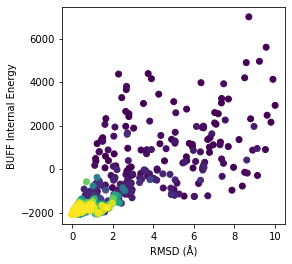

In [14]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('ga.png')

In [15]:
f = open('d_CC-Di_tetramer_antiparallel-optimized-model-ga.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_ga.pdb)

### Differential Evolution

In [16]:
opt_de = ev_opts.DE(APHomoTetramer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [17]:
opt_de.run_opt(100, 30, cores=8)

gen	evals	avg    	std    	min     	max    
0  	100  	367.166	1400.52	-1960.95	4456.83
1  	100  	-385.531	894.316	-1960.95	2126.76
2  	100  	-793.116	673.74 	-1960.95	1299.53
3  	100  	-1098.09	572.835	-1960.95	465.383
4  	100  	-1349.77	435.855	-2015.03	-327.917
5  	100  	-1521.05	372.84 	-2015.03	-500.863
6  	100  	-1648.67	289.395	-2015.03	-754.915
7  	100  	-1801.48	164.526	-2018.87	-1340.62
8  	100  	-1860.19	121.217	-2023.23	-1432.14
9  	100  	-1901.32	92.5881	-2036.58	-1609.21
10 	100  	-1937.75	70.503 	-2036.58	-1620.6 
11 	100  	-1957.64	48.6834	-2036.58	-1764.65
12 	100  	-1976.29	39.9201	-2065.68	-1829.33
13 	100  	-1989.94	30.4258	-2065.68	-1865.62
14 	100  	-1998.11	25.5979	-2065.68	-1925.27
15 	100  	-2004.53	24.6994	-2067.51	-1925.27
16 	100  	-2009.44	23.2566	-2067.51	-1947.47
17 	100  	-2016.19	21.8089	-2067.51	-1960.95
18 	100  	-2022.12	22.7321	-2076.79	-1960.95
19 	100  	-2026.59	23.2917	-2079.06	-1967.16
20 	100  	-2034.57	22.8582	-2079.06	-1970.43
21 	100  	-2039.8

In [18]:
optimized_model_de = opt_de.best_model
budeff.get_internal_energy(optimized_model_de).total_energy

-2093.328143081514

In [19]:
funnel_data_de = opt_de.make_energy_funnel_data()

In [20]:
xs = [x[0] for x in funnel_data_de]
ys = [x[1] for x in funnel_data_de]
zs = [x[2] for x in funnel_data_de]

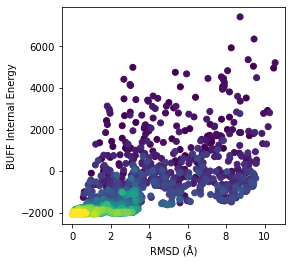

In [21]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('de.png')

In [22]:
f = open('d_CC-Di_tetramer_antiparallel-optimized-model-de.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_de.pdb)

### Particle Swarm Optimisation

In [23]:
opt_pso = ev_opts.PSO(APHomoTetramer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [24]:
opt_pso.run_opt(100, 30, cores=8)

gen	evals	avg   	std    	min     	max    
0  	100  	64.009	1283.41	-2003.94	3434.63
1  	67   	-769.079	1165.99	-2003.94	2774.01
2  	42   	-1020.32	889.737	-2012.88	2291.08
3  	49   	-596.129	938.444	-2012.88	1305.6 
4  	88   	49.7542 	1112.91	-1953.45	3439.79
5  	90   	726.196 	1383.89	-1749.59	5491.7 
6  	79   	3.23312 	1537.35	-1918.94	4977.99
7  	38   	-375.749	1532.8 	-1991.76	4977.99
8  	56   	153.465 	1309.32	-1984.38	4977.99
9  	90   	343.626 	1175.87	-1962.32	2684.99
10 	92   	-368.368	1364.57	-1939.51	5826.73
11 	48   	-571.015	1342.87	-2023.03	5826.73
12 	58   	-72.0664	1200.84	-1959.95	4130.32
13 	74   	-657.401	1166.45	-1995.07	3435   
14 	74   	-660.184	1131.46	-1995.07	2409   
15 	71   	-269.08 	1278.97	-1995.07	5160.05
16 	61   	-27.0186	1448.67	-1995.07	5431.93
17 	49   	-168.156	1443.14	-1995.07	5431.93
18 	63   	-530.711	1119.34	-2005.14	2607.63
19 	62   	-905.808	1000.04	-2005.14	2607.63
20 	46   	-782.022	1124.83	-2005.14	5324.87
21 	41   	-777.194	1107.91	-2005.14	

In [25]:
optimized_model_pso = opt_pso.best_model
budeff.get_internal_energy(optimized_model_pso).total_energy

-2023.0272348337433

In [26]:
funnel_data_pso = opt_pso.make_energy_funnel_data()

In [27]:
xs = [x[0] for x in funnel_data_pso]
ys = [x[1] for x in funnel_data_pso]
zs = [x[2] for x in funnel_data_pso]

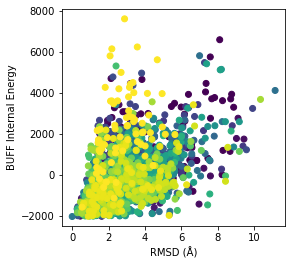

In [28]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('pso.png')

In [29]:
f = open('d_CC-Di_tetramer_antiparallel-optimized-model-pso.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_pso.pdb)

### Covariance Matrix Adaptive Evolutionary Strategy

In [30]:
opt_cmaes = ev_opts.CMAES(APHomoTetramer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [31]:
opt_cmaes.run_opt(100, 30, cores=8)

gen	evals	avg   	std   	min     	max    
0  	100  	1165.6	878.74	-596.876	5088.32
1  	100  	320.272	1290.27	-1828.56	4477.06
2  	100  	-160.592	1752.95	-1932.76	5225.63
3  	100  	-1084.77	942.849	-1924.73	2187.35
4  	100  	-1571.35	435.098	-2014.27	397.436
5  	100  	-1691.39	261.141	-2059.7 	523.993
6  	100  	-1717.54	142.421	-2021.28	-1169.41
7  	100  	-1715.86	179.499	-1993.88	-879.503
8  	100  	-1729.19	225.127	-2028.58	-683.87 
9  	100  	-1664.34	370.016	-2087.42	66.0519 
10 	100  	-1757.74	239.171	-2082.61	-960.387
11 	100  	-1878.79	115.611	-2067.07	-1497.4 
12 	100  	-1928.95	99.8856	-2083.08	-1524.74
13 	100  	-1978.85	54.9679	-2083.43	-1818.83
14 	100  	-1994.54	51.6953	-2086.27	-1826   
15 	100  	-2005.34	43.3214	-2086.8 	-1868.82
16 	100  	-2028.93	38.1685	-2089.09	-1910.72
17 	100  	-2038.79	37.9498	-2090.04	-1949.98
18 	100  	-2055.65	29.8224	-2091.75	-1958.74
19 	100  	-2065.19	28.2106	-2092.25	-1962.18
20 	100  	-2072.48	24.4178	-2093.17	-1982.06
21 	100  	-2063.2 	42.12

In [32]:
optimized_model_cmaes = opt_cmaes.best_model
budeff.get_internal_energy(optimized_model_cmaes).total_energy

-2095.3401532559974

In [33]:
funnel_data_cmaes = opt_cmaes.make_energy_funnel_data()

In [34]:
xs = [x[0] for x in funnel_data_cmaes]
ys = [x[1] for x in funnel_data_cmaes]
zs = [x[2] for x in funnel_data_cmaes]

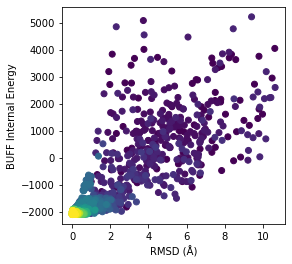

In [35]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('cmaes.png')

In [36]:
f = open('d_CC-Di_tetramer_antiparallel-optimized-model-cmaes.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_cmaes.pdb)